In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np

import os
from xml.etree import ElementTree

from mrcnn.utils import Dataset, compute_ap
from mrcnn.config import Config
from mrcnn.model import MaskRCNN, load_image_gt, mold_image
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Using TensorFlow backend.


# Object Detection using Mask R-CNN
---

## Parsing input files

In [3]:
# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    
    return boxes, width, height

In [4]:
# extract details form annotation file
boxes, w, h = extract_boxes('od_rcnn/kangaroo/annots/00001.xml')
# summarize extracted details
print(boxes, w, h)

[[233, 89, 386, 262], [134, 105, 341, 253]] 450 319


## Kangaroo Dataset Object

In [5]:
# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in os.listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        return boxes, width, height
    
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        
        return masks, np.asarray(class_ids, dtype='int32')
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        
        return info['path']

In [6]:
# train set
train_set = KangarooDataset()
train_set.load_dataset('od_rcnn/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = KangarooDataset()
test_set.load_dataset('od_rcnn/kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 131
Test: 32


## Testing Kangaroo Dataset Object

(532, 800, 3)
(532, 800, 1)


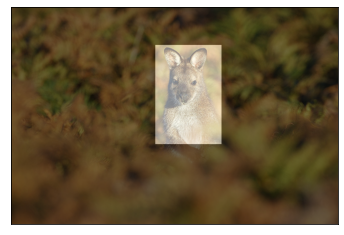

In [22]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
img_fig = plt.imshow(image)
# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
# hide scales
img_fig.axes.get_xaxis().set_visible(False)
img_fig.axes.get_yaxis().set_visible(False)
plt.show()

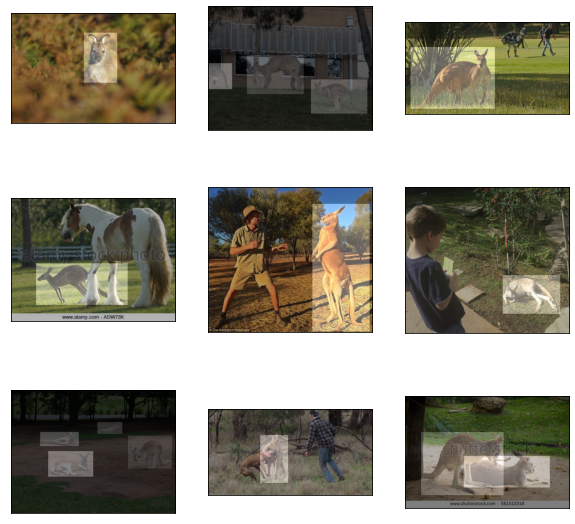

In [20]:
# plot first few images
plt.figure(figsize=(10, 10))
for i in range(9):
    # define subplot
    img_fig = plt.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
    plt.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    for j in range(mask.shape[2]):
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
    # hide scales
    img_fig.axes.get_xaxis().set_visible(False)
    img_fig.axes.get_yaxis().set_visible(False)
# show & save the figure
plt.savefig('od_rcnn/train_examples.png')
plt.show()

In [9]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
    # load image info
    info = train_set.image_info[image_id]
    # display on the console
    print(info)

{'id': '00081', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images/00081.jpg', 'annotation': 'od_rcnn/kangaroo/annots/00081.xml'}
{'id': '00137', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images/00137.jpg', 'annotation': 'od_rcnn/kangaroo/annots/00137.xml'}
{'id': '00136', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images/00136.jpg', 'annotation': 'od_rcnn/kangaroo/annots/00136.xml'}
{'id': '00125', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images/00125.jpg', 'annotation': 'od_rcnn/kangaroo/annots/00125.xml'}
{'id': '00117', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images/00117.jpg', 'annotation': 'od_rcnn/kangaroo/annots/00117.xml'}
{'id': '00026', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images/00026.jpg', 'annotation': 'od_rcnn/kangaroo/annots/00026.xml'}
{'id': '00048', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images/00048.jpg', 'annotation': 'od_rcnn/kangaroo/annots/00048.xml'}
{'id': '00131', 'source': 'dataset', 'path': 'od_rcnn/kangaroo/images

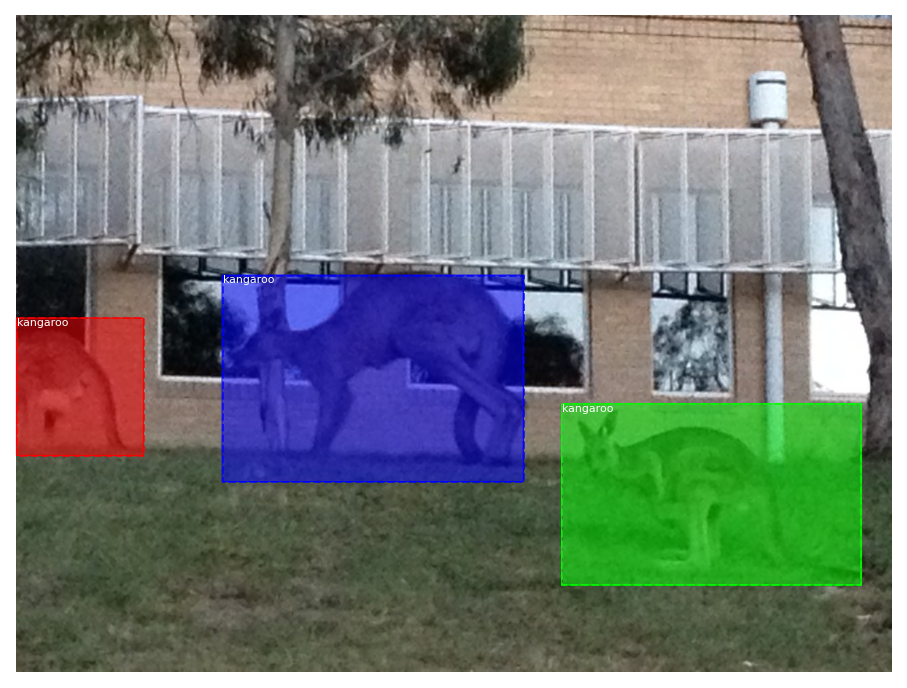

In [10]:
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

## Training Mask R-CNN Model for Kangaroo Detection

In [11]:
# define a configuration for the model
class KangarooConfig(Config):
    # Give the configuration a recognizable name
    NAME = "kangaroo_cfg"
    # Number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131

# prepare config
config = KangarooConfig()

In [12]:
# define the model
model = MaskRCNN(mode='training', model_dir='./od_rcnn', config=config)
model.keras_model.metrics_tensors = []

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# load weights (mscoco)
model.load_weights('od_rcnn/mask_rcnn_coco.h5', by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [14]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./od_rcnn/kangaroo_cfg20200616T2126/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/keras/engine/training_genera

Epoch 1/5
131/131 [==============================] - 4524s 35s/step - loss: 0.8635 - val_loss: 0.7276
Epoch 2/5
131/131 [==============================] - 4470s 34s/step - loss: 0.6460 - val_loss: 1.8546
Epoch 3/5
131/131 [==============================] - 4511s 34s/step - loss: 0.7054 - val_loss: 0.9137
Epoch 4/5
131/131 [==============================] - 4473s 34s/step - loss: 0.6087 - val_loss: 0.6227
Epoch 5/5
131/131 [==============================] - 4470s 34s/step - loss: 0.5483 - val_loss: 0.6592
Epoch 1/5
Epoch 1/5


## Evaluating a Mask R-CNN Model

In [11]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [12]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    
    return mAP

In [13]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./od_rcnn', config=cfg)
# load model weights
model.load_weights('od_rcnn/kangaroo_cfg20200616T2126/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Re-starting from epoch 5
Train mAP: 0.873
Test mAP: 0.921


## Detecting Kangaroos in New Photos

In [26]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5, save_file=None):
    plt.figure(figsize=(10, 10))
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        img_fig = plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
        # hide scales
        img_fig.axes.get_xaxis().set_visible(False)
        img_fig.axes.get_yaxis().set_visible(False)
    # show & save the figure
    if save_file:
        plt.savefig(save_file)
    plt.show()

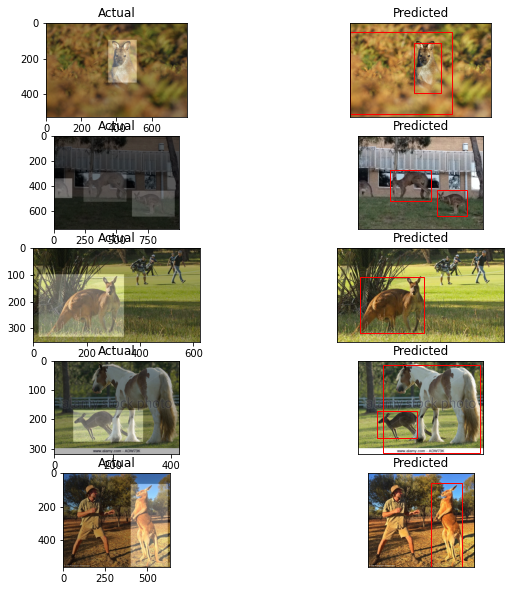

In [27]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg, save_file='od_rcnn/train_set_predictions.png')

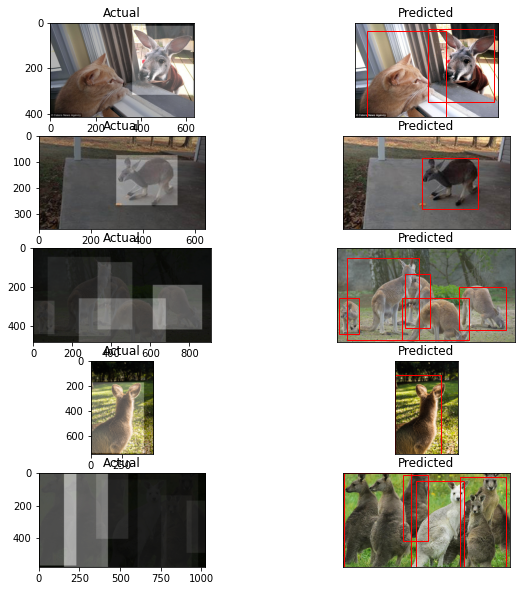

In [28]:
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg, save_file='od_rcnn/test_set_predictions.png')